# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import model
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 7
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-3
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob('../../vocalfolds/img/*/*/*.png')
MASK_DATASET_PATH  = glob('../../vocalfolds/annot/*/*/*.png')

N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 536


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[0],[1],[2],[3],[4],[5],[6]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (NUM_CLASSES, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=NUM_CLASSES, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
_, testImages, _, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = torch.nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [11]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformer.pth')
uformer.load_state_dict(torch.load('../models/vf_uformer.pth'))

<All keys matched successfully>

In [12]:
def make_prediction(model, image, toCategorical=True):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		if toCategorical:
			predMask = np.argmax(predMask, axis=-1)
			predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [13]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

In [14]:
pred = []
y_true = []
print('[INFO] Loading test images...')
for testImg in tqdm(testImages):
    pred.append(make_prediction(uformer, getPredImg(testImg)))

print('[INFO] Loading test masks...')
for testMask in tqdm(testMasks):
    testMask = getPredMask(testMask)
    testMask = np.argmax(testMask, axis=-1)
    testMask = np.expand_dims(testMask, axis=-1)
    y_true.append(testMask)

pred = np.array(pred)
y_true = np.array(y_true)

assert pred.shape == y_true.shape, f"{pred.shape} != {y_true.shape}"

[INFO] Loading test images...


100%|██████████| 108/108 [00:04<00:00, 21.80it/s]


[INFO] Loading test masks...


100%|██████████| 108/108 [00:00<00:00, 870.98it/s]


In [15]:
labels_encoding = {
    0: 'void',
    1: 'vocal folds',
    2: 'other tissue',
    3: 'glottal space',
    4: 'pathology',
    5: 'surgical tool',
    6: 'intubation',
}

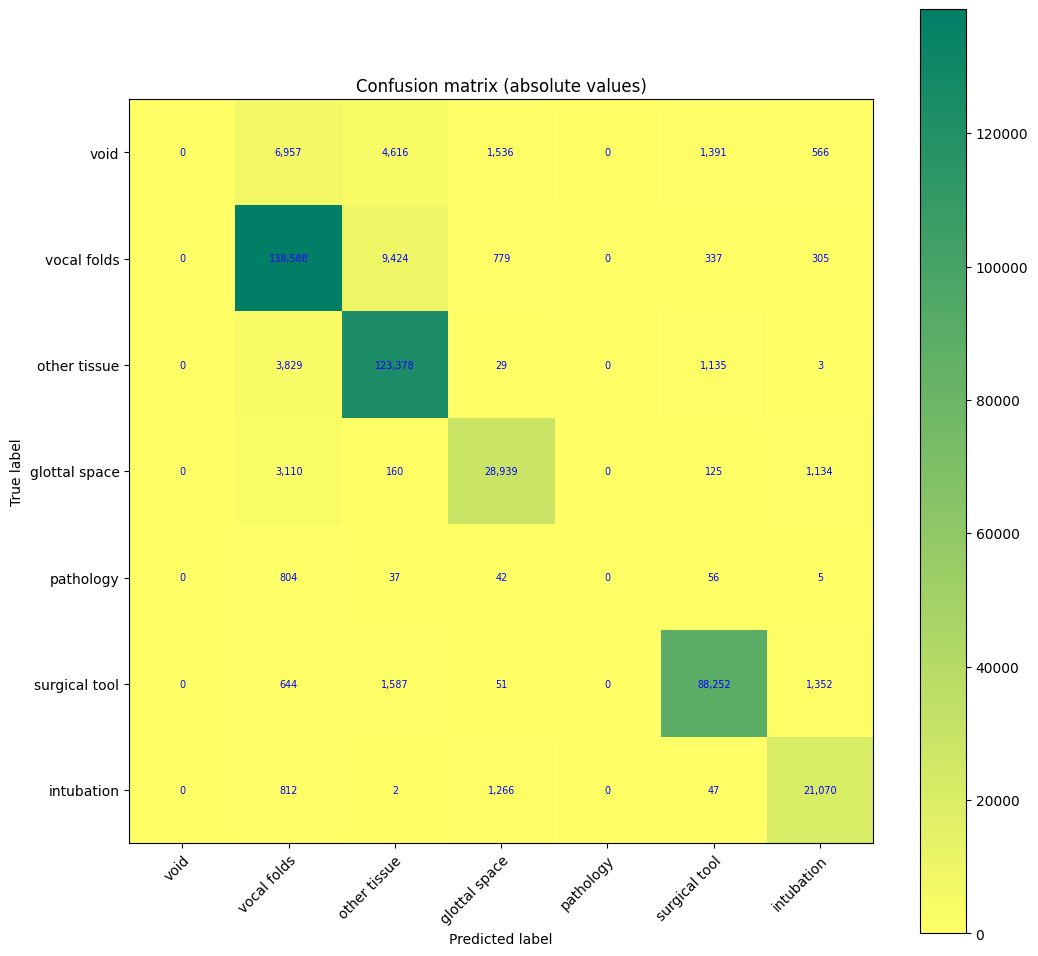

In [16]:
from sklearn.metrics import confusion_matrix

y_true = y_true.reshape((-1, 1))
y_pred = pred.reshape((-1, 1))
confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,12))
plt.xticks(np.arange(0,NUM_CLASSES, 1), labels=labels_encoding.values(), rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(0,NUM_CLASSES, 1), labels=labels_encoding.values())
plt.title('Confusion matrix (absolute values)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(confusion_mat, cmap='summer_r')
plt.colorbar()
for i in range(len(confusion_mat)):
    for j in range(len(confusion_mat[0])):
        plt.text(j, i, f"{confusion_mat[i, j]:,}",
                       ha="center", va="center", color="b", fontsize='x-small')
plt.show()

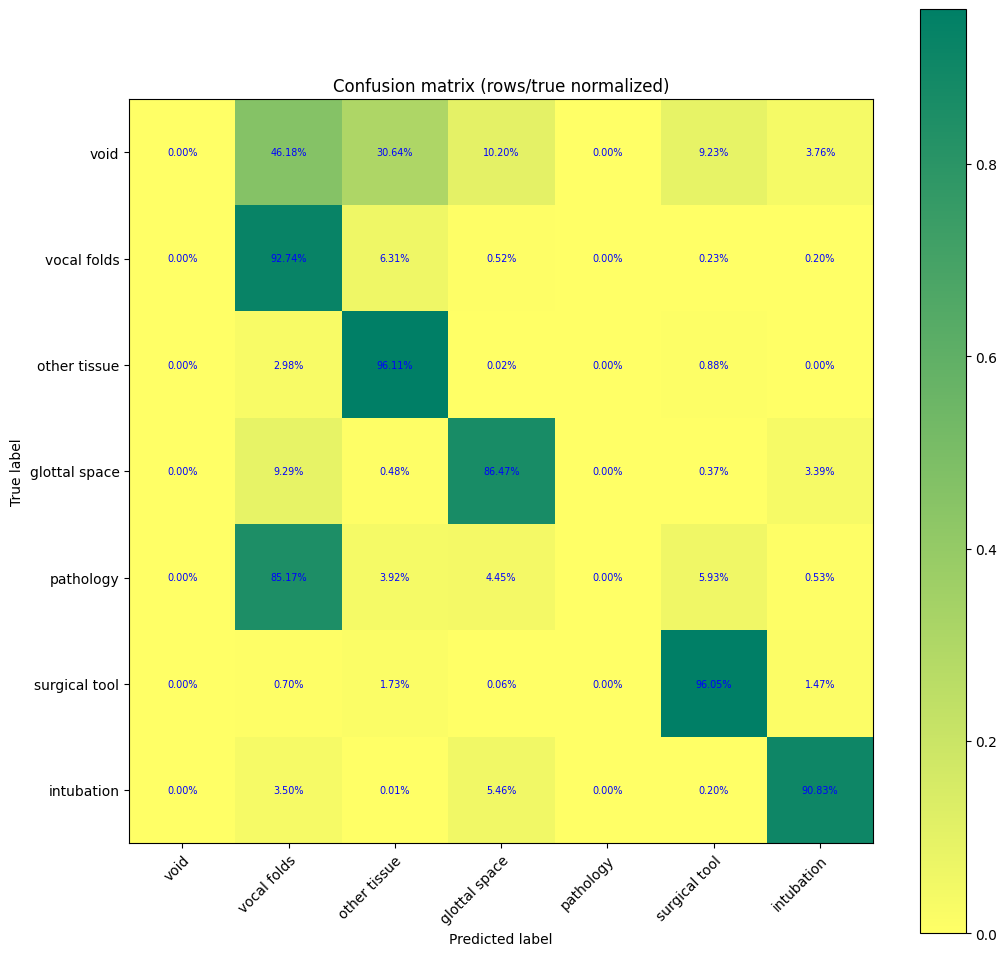

In [17]:
confusion_mat = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(12,12))
plt.xticks(np.arange(0,NUM_CLASSES, 1), labels=labels_encoding.values(), rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(0,NUM_CLASSES, 1), labels=labels_encoding.values())
plt.title('Confusion matrix (rows/true normalized)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(confusion_mat, cmap='summer_r')
plt.colorbar()
for i in range(len(confusion_mat)):
    for j in range(len(confusion_mat[0])):
        plt.text(j, i, f"{confusion_mat[i, j]*100:.2f}%",
                       ha="center", va="center", color="b", fontsize='x-small')
plt.show()

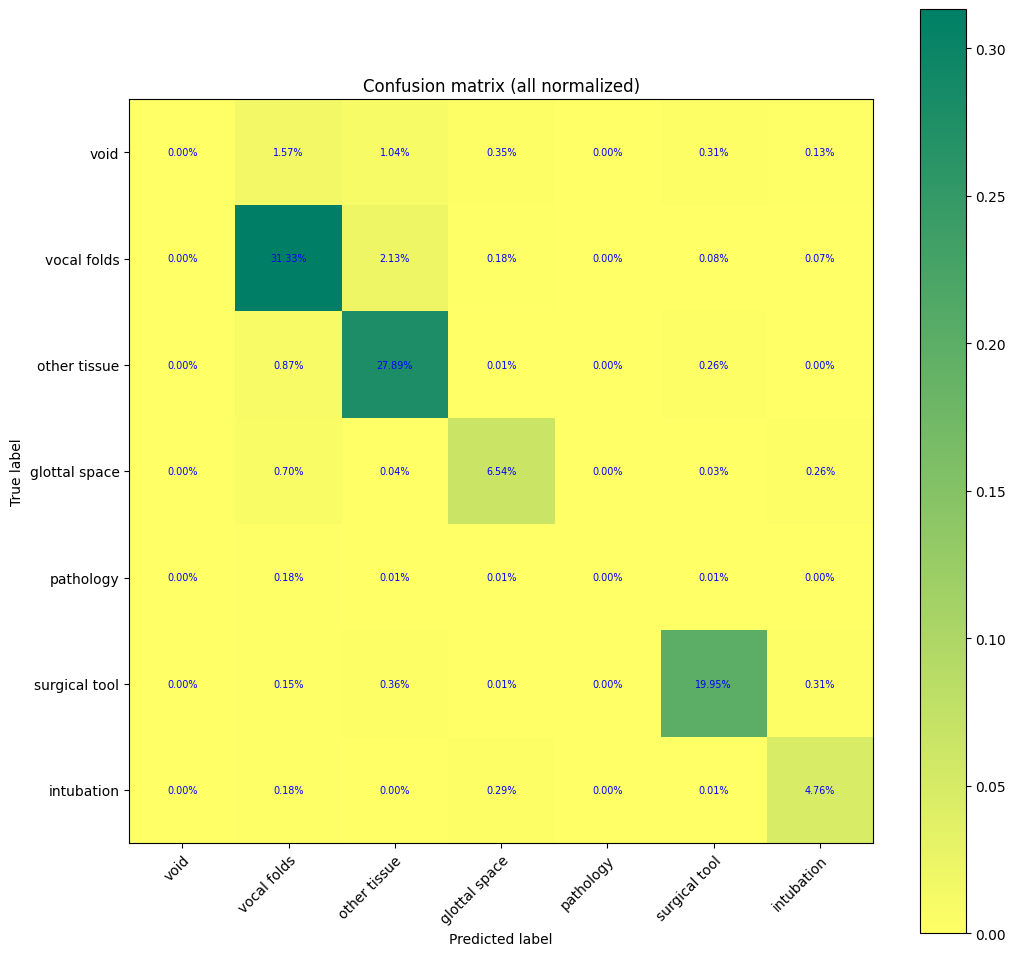

In [18]:
confusion_mat = confusion_matrix(y_true, y_pred, normalize='all')

plt.figure(figsize=(12,12))
plt.xticks(np.arange(0,NUM_CLASSES, 1), labels=labels_encoding.values(), rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(0,NUM_CLASSES, 1), labels=labels_encoding.values())
plt.title('Confusion matrix (all normalized)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(confusion_mat, cmap='summer_r')
plt.colorbar()
for i in range(len(confusion_mat)):
    for j in range(len(confusion_mat[0])):
        plt.text(j, i, f"{confusion_mat[i, j]*100:.2f}%",
                       ha="center", va="center", color="b", fontsize='x-small')
plt.show()

In [19]:
pred = []
y_true = []
print('[INFO] Loading test images...')
for testImg in tqdm(testImages):
    pred.append(make_prediction(uformer, getPredImg(testImg), toCategorical=False))

print('[INFO] Loading test masks...')
for testMask in tqdm(testMasks):
    testMask = getPredMask(testMask)
    y_true.append(testMask)

pred = np.array(pred)
y_true = np.array(y_true)

assert pred.shape == y_true.shape, f"{pred.shape} != {y_true.shape}"

[INFO] Loading test images...


100%|██████████| 108/108 [00:03<00:00, 29.13it/s]


[INFO] Loading test masks...


100%|██████████| 108/108 [00:00<00:00, 806.00it/s]


In [20]:
dice = losses.DiceCoeficient().cuda()
iou = losses.MeanIoUBinary().cuda()

prediction = torch.Tensor(pred)
target = torch.Tensor(y_true)

class_losses = {
    'Dice Coeficient' : [],
    'IoU' : [],
}

for i in range(NUM_CLASSES):
    class_losses['Dice Coeficient'].append(dice(target[:,:,:,i], prediction[:,:,:,i]).numpy())
    class_losses['IoU'].append(iou(target[:,:,:,i], prediction[:,:,:,i]).numpy())
    
class_losses['Dice Coeficient'].append(dice(target, prediction).numpy())
class_losses['IoU'].append(iou(target, prediction).numpy())

indexes = list(labels_encoding.values())

indexes.append('Final')

pd.options.display.float_format = '{:.4f}'.format

df = pd.DataFrame(class_losses, index=indexes)
df['Dice Coeficient'] = df['Dice Coeficient'].map('{:.5f}'.format)
df['IoU'] = df['IoU'].map('{:.5f}'.format)

df

,Dice Coeficient,IoU
void,0.00000,0.00000
vocal folds,0.84001,0.72416
other tissue,0.89946,0.81730
glottal space,0.58830,0.41673
pathology,0.00000,0.00000
surgical tool,0.87290,0.77447
intubation,0.57264,0.40119
Final,0.82087,0.69616


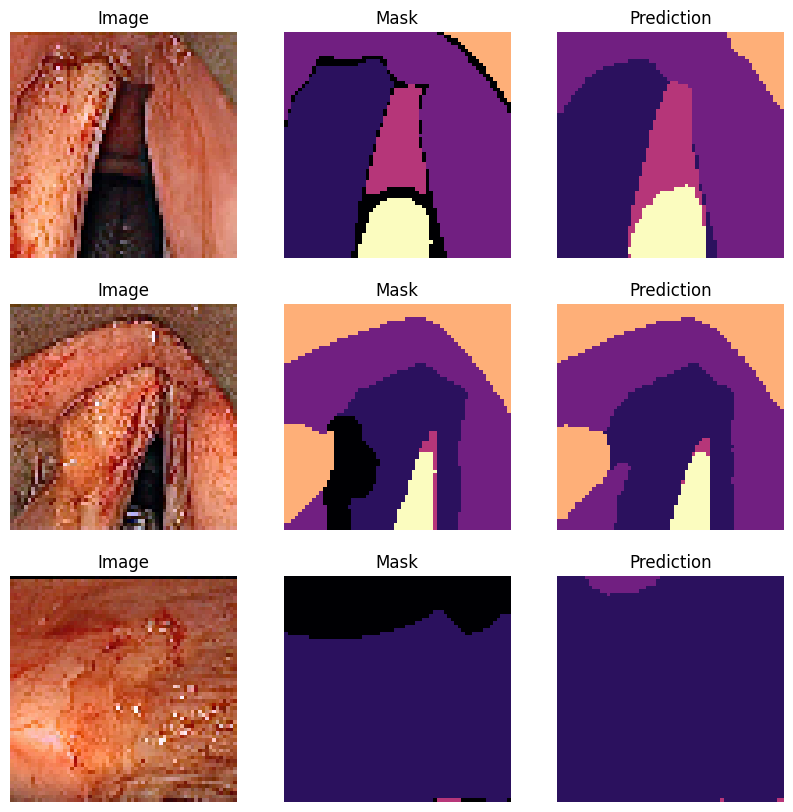

In [21]:
idxs = [44, 100, 11]
plt.figure(figsize=(10,10))
for i in range(3):    
    idx = idxs[i]

    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota